In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
products = pd.read_csv('Downloads/mo_c/customers.csv')
orders= pd.read_csv('Downloads/mo_c/orders.csv')
customers = pd.read_csv('Downloads/mo_c/products.csv')

In [4]:
df01 = pd.merge(products,orders)
d_f = pd.merge(df01,customers)

In [5]:
d_f['Revenue'] = d_f['Unit Price'] * d_f['Quantity']

In [6]:
df = d_f[['Order Date','Revenue']]

In [7]:
df.columns=['Date', 'Revenue']

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=False) # True : to set date as index
df.head()

,Date,Revenue
0,2019-09-05,19.90
1,2019-09-05,41.25
2,2021-06-17,12.95
3,2021-07-15,27.50
4,2021-07-15,54.97


In [9]:
# sorting date vslues
df = df.sort_values(by='Date',ascending=True)

In [10]:
# Re-sampling the data : reducing frequency
df = df.resample('M', on='Date').sum()

<Axes: xlabel='Date'>

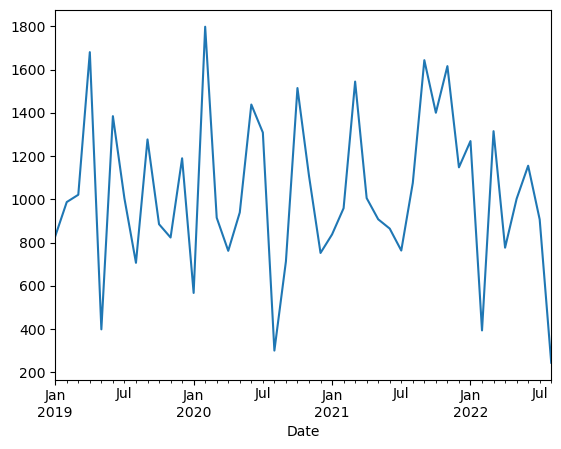

In [11]:
df['Revenue'].plot()

In [12]:
# Trend is linear
# D = 1

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

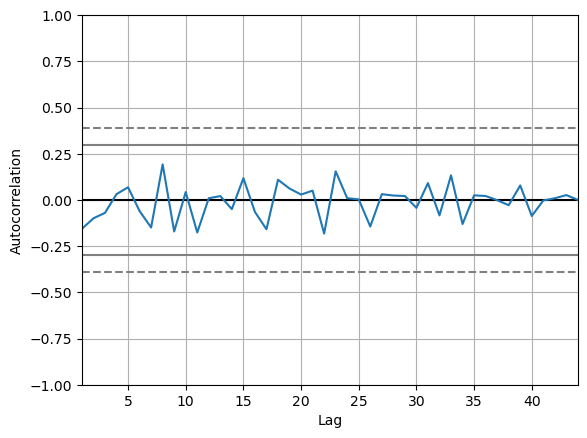

In [13]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Revenue'])

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf

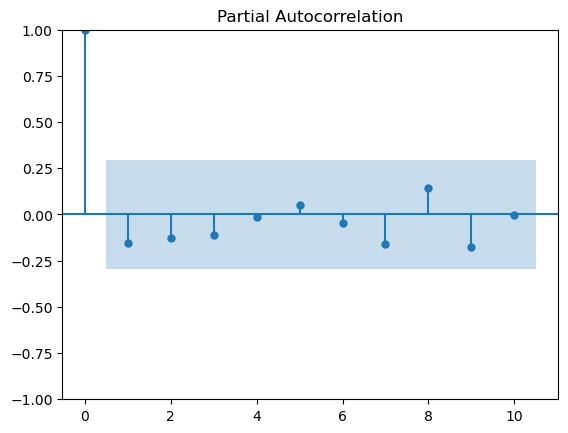

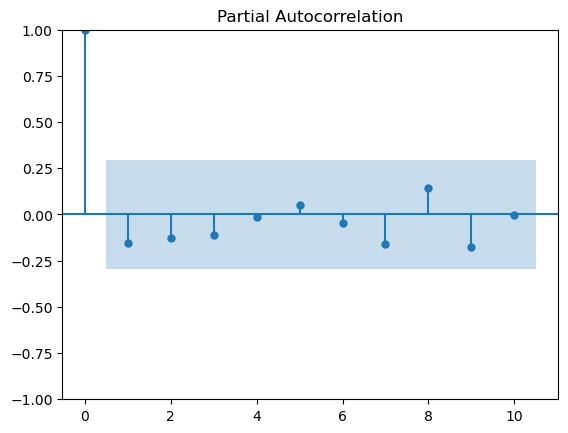

In [15]:
plot_pacf(df['Revenue'], lags=10)

In [16]:
from statsmodels.tsa.arima_model import ARIMA

In [17]:
from statsmodels.tsa.arima.model import ARIMA  # <- note the extra `.model`
model = ARIMA(df, order=(1,1,1))

In [18]:
model_fit = model.fit()

In [19]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Revenue   No. Observations:                   44
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -316.920
Date:                Mon, 22 Sep 2025   AIC                            639.840
Time:                        23:43:51   BIC                            645.123
Sample:                    01-31-2019   HQIC                           641.788
                         - 08-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1474      0.184     -0.801      0.423      -0.508       0.213
ma.L1         -0.9998     22.999     -0.043      0.965     -46.076      44.077
sigma2      1.337e+05   3.08e+06      0.043      0.965    -5.9e+06    6.17e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.34
Prob(Q):                              0.82   Prob(JB):                         0.84
Heteroskedasticity (H):               1.30   Skew:                            -0.07
Prob(H) (two-sided):                  0.63   Kurtosis:                         2.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
residuals = model_fit.resid

<Axes: xlabel='Date'>

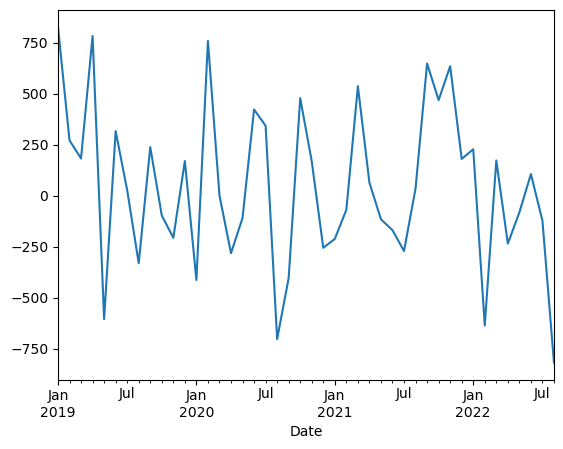

In [21]:
residuals.plot()

In [22]:
residuals.describe()

count     44.000000
mean      44.413117
std      401.378906
min     -818.183788
25%     -216.774991
50%       31.908077
75%      283.229012
max      828.985000
dtype: float64

In [23]:
output = model_fit.forecast()

In [24]:
output

2022-09-30    1141.403943
Freq: ME, dtype: float64

In [25]:
df.tail()

,Revenue
Date,
2022-04-30,776.450
2022-05-31,1002.370
2022-06-30,1155.390
2022-07-31,906.730
2022-08-31,244.245


In [26]:
model_fit.forecast(5)[0]

1141.403942861808

In [27]:
# - - - Walk Forward ARIMA - - - 

In [28]:
train_size = int(df.shape[0]*0.7)

In [29]:
train_size

30

In [30]:
train, test = df.Revenue[0:train_size], df.Revenue[train_size:]

In [31]:
test.shape

(14,)

In [32]:
data = pd.Series(train)  # Ensure train is a Series
predict = []

for t in test:
    try:
        model = ARIMA(data, order=(1, 1, 1))
        model_fit = model.fit()

        # Get 1-step forecast
        y = model_fit.forecast(steps=1)

        # Safely get the forecasted value
        y_value = y.iloc[0] if hasattr(y, 'iloc') else y[0]
        print(y_value)
        predict.append(y_value)

    except Exception as e:
        print(f"Model failed at step with error: {e}")
        predict.append(np.nan)  # Append NaN if model fails

    # Append actual value from test set
    data = pd.concat([data, pd.Series([t])], ignore_index=True)


1058.125343379121
1075.4850087143182
986.5995590123994
853.0759446637751
965.3605867344629
975.2937288043627
1063.0337849620996
1089.5858739894643
1133.7657631650122
1007.1914724095719
1090.8312607852517
1049.751497495962
1026.5205866274669
1066.2613139383275


In [33]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test.values, predict)
mse

185268.50666347865